# Beam Solving using simulations

In [1]:
%matplotlib notebook
import pylab as plt, numpy as np
import pyuvdata, uvtools, hera_cal, aipy
import time
import linsolve
import healpy as hp
import pylab
from matplotlib import cm
from astropy.io import fits
from astropy import wcs
import copy
import pickle
import glob
import fits_utils as ft
import coord_tools as ct
from collections import OrderedDict

Generate 2D gaussian beam as the primary beam model

In [3]:
bm_pix = 31
bm_true = np.zeros((bm_pix, bm_pix), dtype=float)
bmx, bmy = np.indices(bm_true.shape)
mu = 15.; sigma=3.
bm_true = np.exp(-((bmx-mu)**2 + (bmy-mu)**2)/ (2 * sigma**2))

Convert pixels to topocentric coordinates

In [4]:
def recenter(a, c):
    """Slide the (0,0) point of matrix a to a new location tuple c.  This is
    useful for making an image centered on your screen after performing an
    inverse fft of uv data."""
    s = a.shape
    c = (c[0] % s[0], c[1] % s[1])
    if np.ma.isMA(a):
        a1 = np.ma.concatenate([a[c[0]:], a[:c[0]]], axis=0)
        a2 = np.ma.concatenate([a1[:,c[1]:], a1[:,:c[1]]], axis=1)
    else:
        a1 = np.concatenate([a[c[0]:], a[:c[0]]], axis=0)
        a2 = np.concatenate([a1[:,c[1]:], a1[:,:c[1]]], axis=1)
    return a2

def get_LM(dim, center=(0,0), res=1):
        """Get the (l,m) image coordinates for an inverted UV matrix."""
        M,L = np.indices((dim, dim))
        L,M = np.where(L > dim/2, dim-L, -L), np.where(M > dim/2, M-dim, M)
        L,M = L.astype(np.float32)/dim/res, M.astype(np.float32)/dim/res
        mask = np.where(L**2 + M**2 >= 1, 1, 0)
        L,M = np.ma.array(L, mask=mask), np.ma.array(M, mask=mask)
        return recenter(L, center), recenter(M, center)

def get_top(dim, center=(0,0), res=1):
    """Return the topocentric coordinates of each pixel in the image."""
    x,y = get_LM(dim, center, res)
    z = np.sqrt(1 - x**2 - y**2)
    return x,y,z

In [5]:
tx0, ty0, tz0 = get_top(bm_pix, center=(15,15), res=1)
tx00, ty00, tz00 = tx0.flatten(), ty0.flatten(), tz0.flatten()
indices = np.arange(bm_pix**2)
bm_true_f = bm_true.flatten()

Generate a set of point sources. Here we took each pixel of the $31 \times 31$ grid to be a point source.

In [12]:
azs, alts = aipy.coord.top2azalt([np.array(tx0[:, :]), np.array(ty0[:,:]), np.array(tz0[:, :])])
azs = np.rad2deg(azs); alts= np.rad2deg(alts)
peaks = np.random.random(40) + 10
_sh = azs.shape

Constructing system of linear equations using the constructed gaussian beam model and the catalogue of point sources. The beam value at a given position $(t_x, t_y, t_z)$ can be given by the four nearest coordinates:

\begin{equation}
A_s(t_x, t_y, t_z) = \frac{\sum_{i=0}^4 b_iw_i(t_{x_i}, t_{y_i}, t_{z_i})}{\sum_{i=0}^4 w_i(t_{x_i}, t_{y_i}, t_{z_i})}
\end{equation}

where $w_i = \frac{1}{d_i}$, $d_i$ is the distance from the point $(t_x, t_y, t_z)$ to $(t_{x_i}, t_{y_i}, t_{z_)$.

Using the 4 closest point linear interpolation, we can construct a system of linear equations:

\begin{align}
I^{obs} &= I^M(t_x, t_y, t_z).A_s(t_x, t_y, t_z) \\
        &= I^M\Bigg(\frac{\sum_{i=0}^4 b_iw_i(t_{x_i}, t_{y_i}, t_{z_i})}{\sum_{i=0}^4 w_i(t_{x_i}, t_{y_i}, t_{z_i})}\Bigg)
\end{align}

In [10]:
def mk_key(px,i, t):
    return 'w%d_s%d_t%d' % (px,i, t)

consts = OrderedDict()
eqs = OrderedDict()

beam_tracks = np.zeros((_sh))
src_tracks = np.zeros((_sh))
interp2d = np.zeros((bm_pix**2))

time0 = time.time()
for i in range(_sh[0]):
    #consts = OrderedDict()
    #eqs = OrderedDict()
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(azs[i,:]), np.deg2rad(alts[i,:])])
    for j in range(_sh[1]):
        dist = np.sqrt((tx00 - tx[j])**2 + (ty00 - ty[j])**2)
        inds = np.argsort(dist)
    
        if dist[inds[0]] == 0.0:
            p0, w0 = indices[inds[0]], 1
            p1, w1 = 0, 0
            p2, w2 = 0, 0
            p3, w3 = 0 ,0
        else:
            p0, w0 = indices[inds[0]], dist[inds[0]]**(-1)
            p1, w1 = indices[inds[1]], dist[inds[1]]**(-1)
            p2, w2 = indices[inds[2]], dist[inds[2]]**(-1)
            p3, w3 = indices[inds[3]], dist[inds[3]]**(-1)
            
        A_s = (bm_true_f[p0] * w0 + bm_true_f[p1] * w1 + bm_true_f[p2] * w2 + bm_true_f[p3] * w3 )/(w0 + w1 + w2 + w3) 
        I_s =  peaks[i] * A_s
        beam_tracks[i,j] = A_s
        src_tracks[i,j] = I_s
        ps = [p0, p1, p2, p3]
        ws = [w0, w1, w2, w3]
        #print p0, p1, p2, p3
        
        c = {mk_key(ps[p], i, j): peaks[i] * ws[p] for p in xrange(len(ps))}
        eq = '+ '.join([mk_key(ps[p],i, j) + '*b%d'%ps[p] for p in xrange(len(ps))])
        weights = w0 + w1 + w2 + w3
        eqs[eq] = I_s * weights
        consts.update(c)
       
eqs_noise = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_noise, **consts)
sol = ls.solve(verbose=True)
        
for key in sol.keys():
    px = int(key.strip('b'))     
    interp2d[px] = sol.get(key)

print (time.time() - time0)

Solving 0/1
2.37871289253


<IPython.core.display.Javascript object>


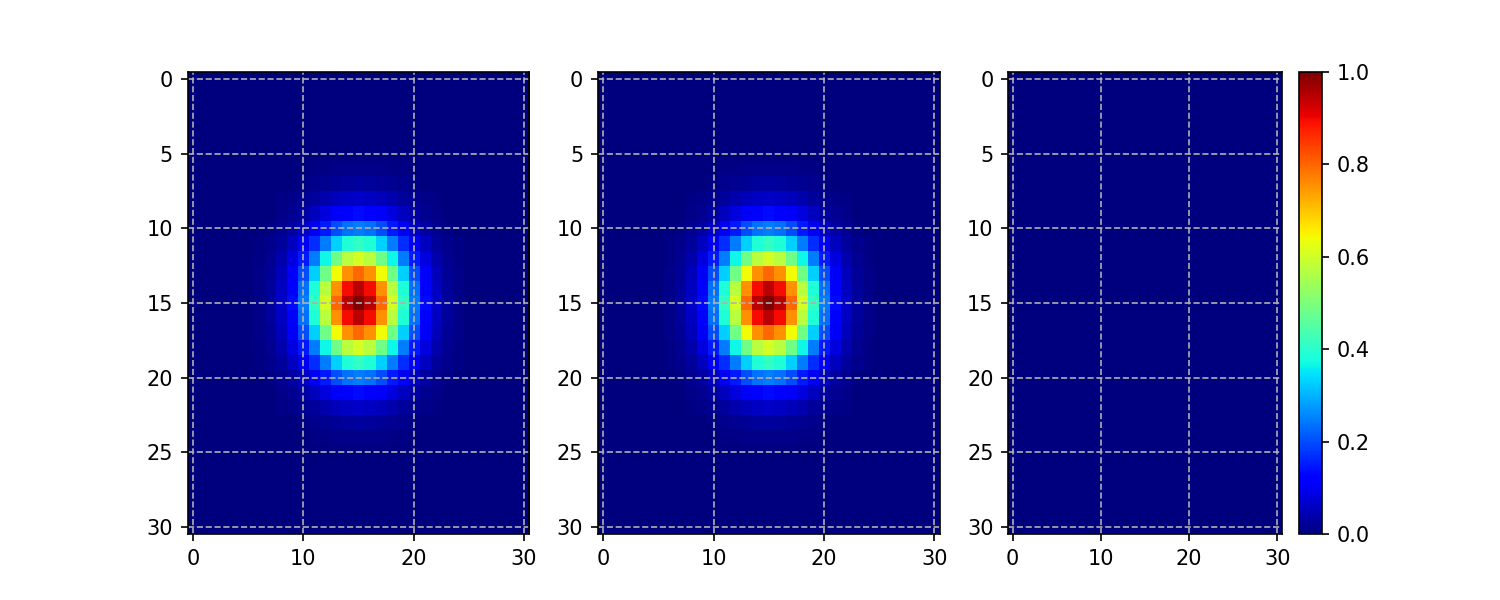

In [11]:
pylab.figure(figsize=(10,4))
pylab.subplot(131)
pylab.imshow(np.abs(bm_true), aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.grid(ls='dashed')

pylab.subplot(132)
pylab.imshow(np.abs(interp2d.reshape(31,31)), aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.grid(ls='dashed')

pylab.subplot(133)
pylab.imshow(bm_true-interp2d.reshape(31,31), aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.grid(ls='dashed')
pylab.colorbar()

In [7]:
def mk_key(px, i, t):
    return 'w%d_s%d_t%d' % (px, i, t)

def unravel_pix(n, i,j):
    return (i*n) + j
    

consts = OrderedDict()
eqs = OrderedDict()

beam_tracks = np.zeros((_sh))
src_tracks = np.zeros((_sh))
interp2d = np.zeros((bm_pix**2))

time0 = time.time()
for i in range(_sh[0]):
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(azs[i,:]), np.deg2rad(alts[i,:])])
    tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)#tx_px0 + 1
    fx = tx_px - tx_px0
    ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)#ty_px0 + 1
    fy = ty_px - ty_px0
    x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
    x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
    x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
    x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)
    
    w0 = ((1 - fx) * (1 - fy))**(-1)
    w1 = (fx * (1 - fy))**(-1)
    w2 = ((1 - fx) * fy)**(-1)
    w3 = (fx * fy)**(-1)
    
    ps = [x0y0, x0y1, x1y0, x1y1]
    ws = [w0, w1, w2, w3]
        
    for j in range(_sh[1]):
        weights = w0[j] + w1[j] + w2[j] + w3[j]
        A_s = (bm_true[tx_px0[j],ty_px0[j]] * w0[j] + bm_true[tx_px0[j],ty_px1[j]] * w1[j] + \
          bm_true[tx_px1[j],ty_px0[j]] * w2[j] + bm_true[tx_px1[j], ty_px1[j]] * w3[j])/weights
        I_s = peaks[i] * A_s
       
        c = {mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j): peaks[i] * ws[p][j] for p in xrange(len(ps))}
        eq = ' + '.join([mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j) + \
             '*b%d'%(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j])) for p in xrange(len(ps))])     
        eqs[eq] = I_s * weights
        consts.update(c)
eqs_noise = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_noise, **consts)

sol = ls.solve(verbose=True)

for key in sol.keys():
    px = int(key.strip('b'))     
    interp2d[px] = sol.get(key)
        
print (time.time() - time0)

Solving 0/1
0.42228603363


<IPython.core.display.Javascript object>


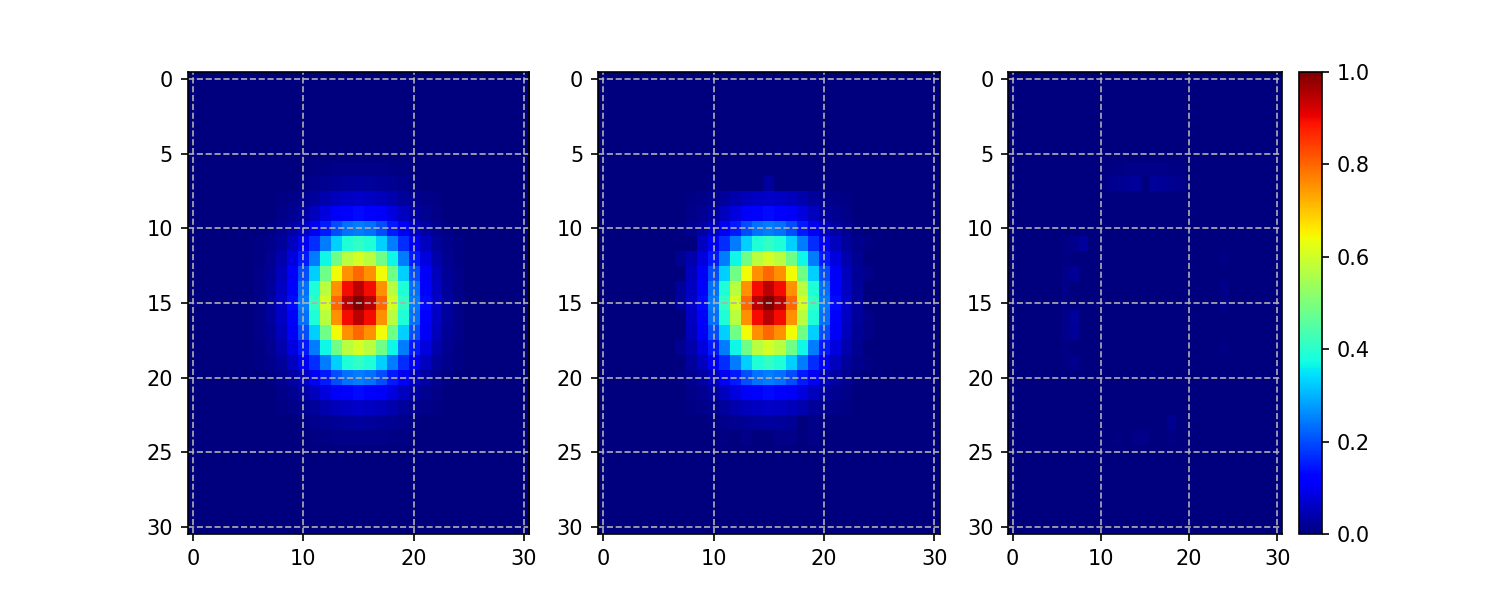

In [8]:
pylab.figure(figsize=(10,4))
pylab.subplot(131)
pylab.imshow(np.abs(bm_true), aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.grid(ls='dashed')

pylab.subplot(132)
pylab.imshow(np.abs(interp2d.reshape(31,31)), aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.grid(ls='dashed')

pylab.subplot(133)
pylab.imshow(bm_true-interp2d.reshape(31,31), aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.grid(ls='dashed')
pylab.colorbar()